In [182]:
# Importing required packages

import numpy as np
import random
import collections
import matplotlib.pyplot as plt

In [165]:
# Reading words from the given URL of Scrabble 4-letter words
with open('word_list.txt', 'r') as f:
    words = np.array(f.read().split())

In [166]:
# Selecting possible words as only those with no repetition of letters
possible_words = np.array([word for word in words if len(word) == len(set(list(word)))])

In [167]:
# Function to return the number of cats and dogs for a given input pair of words
def catsDogs(adv_word, alg_word):
    common_letters = len(set(adv_word) & set(alg_word))
    dogs = sum([let1==let2 for let1, let2 in zip(list(adv_word), list(alg_word))])
    cats = common_letters - dogs
    
    return (cats, dogs)

In [168]:
# Since the cats-dogs values matrix (2D array) cannot store tuples, we map tuples to integers for storage in the matrix
cats_dogs_dict = {(0,0):1, (1,0): 2, (2,0): 3, (3,0):4, (4,0): 5,
                  (0,1):6, (1,1): 7, (2,1): 8, (3,1):9,
                  (0,2):10, (1,2): 11, (2,2): 12,
                  (0,3):13,
                  (0,4):14}

def calcCatsDogsMatrix(curr_possible_words):
    cats_dogs_matrix = np.zeros((len(curr_possible_words), len(curr_possible_words)))
    for i, alg_word in enumerate(curr_possible_words):
        for j, adv_word in enumerate(curr_possible_words):
            # Owing to the commutative nature of the (cats, dogs) operation, the matrix is symmetric
            # Therefore, if the j,i entry has already been calculated, the i,j entry is equal to it
            if cats_dogs_matrix[j, i] != 0:
                cats_dogs_matrix[i, j] = cats_dogs_matrix[j, i]
            # Else we fill in the integer mapped to the obtained (cats, dogs) value
            else:
                cats_dogs_matrix[i, j] = cats_dogs_dict[catsDogs(adv_word, alg_word)]
    
    return cats_dogs_matrix

# We calculate the initial matrix (the largest one through the algorithm) beforehand, 
# so that we don't have to recalculate for each run of the game

initial_cats_dogs_matrix = calcCatsDogsMatrix(possible_words)

In [193]:
# Function to obtain the best choice based on lowest average next list cardinality

def bestChoice(curr_possible_words):
    avg_lengths_next_list = []
    matrix = 0

    if len(curr_possible_words)==len(possible_words):
        matrix = initial_cats_dogs_matrix
    else:
        # The cats-dogs matrix of only the remaining words is selected
        row_indices = np.in1d(possible_words, curr_possible_words).nonzero()[0]
        matrix = initial_cats_dogs_matrix[row_indices, :][:, row_indices]
        
    for row in matrix:
        # We store the average of squares of frequencies of each cats-dogs value, which is equivalent to average next-set cardinality as explained in the report
        avg_lengths_next_list.append(sum(np.array(list(collections.Counter(row).values()))**2)/len(curr_possible_words))

    # Guess with smallest measure of next round cardinality is picked
    best_choice = curr_possible_words[np.argmin(avg_lengths_next_list)]

    return best_choice

# Since the initial guess is independent of the adversary word, it is the same for any run of the game
# Therefore we evaluate it prior, to save computation
initial_guess = bestChoice(possible_words)

In [196]:
def algorithm(adv_word, possible_words):
    # Creating a copy of list of possible words to narrow down through the algorithm
    curr_possible_words = possible_words

    alg_word = initial_guess

    guess_history = [alg_word]

    no_of_guesses = 1
    while True:
        current_cats_dogs = catsDogs(adv_word, alg_word)

        # SHORTENING THE CURRENT LIST OF POSSIBLE WORDS TO THOSE WHOSE (CATS, DOGS) = ADVERSARY'S (CATS, DOGS) WITH REFERENCE TO OUR CURRENT GUESS
        # This list always includes the adversary word, and necessarily gets shorter with each round
        # With every round, all the words in this list satisfy all the observed (CATS, DOGS) numbers with reference to our guesses (which our adversary word also necessarily satisfies)
        curr_possible_words = np.array([word for word in curr_possible_words 
                                        if catsDogs (alg_word, word) == current_cats_dogs])
        
        # Guessing the best choice of word within our shortened list of candidate words
        # This word has the least average cardinality of the next round word list
        alg_word = bestChoice(curr_possible_words)
        
        guess_history.append(alg_word)

        no_of_guesses += 1

        # Break when the list of candidate words is shortened to 1, or the adversary word is guessed by chance
        if alg_word == adv_word:
            break
        elif len(curr_possible_words)==1:
            break

    return (alg_word, guess_history, no_of_guesses)

In [171]:
## DEMONSTRATING A TRIAL RUN OF THE ALGORITHM

# Selecting a random word as the adversary's word
adversary_word = random.choice(possible_words)

# Running the algorithm on the above-generated adversary word
final_guess, _, num_guesses = algorithm(adversary_word, possible_words)

In [172]:
# Printing final algorithm guess, adversary word, and number of guesses taken

print("Final Guess:", final_guess, "|| Adversary Word:",adversary_word)
if(final_guess == adversary_word):
    print("The word guessed is CORRECT!")
    print("Number of guesses taken = ", num_guesses)
else:
    print("The word guessed is WRONG.")

Final Guess: BEAM || Adversary Word: BEAM
The word guessed is CORRECT!
Number of guesses taken =  5


In [176]:
# Running the algorithm on each word to calculate average number of guesses over all words

guess_info = {}
for word in possible_words:
    final_guess, _, num_guesses = algorithm(word, possible_words)
    # Storing the number of guesses for each word
    guess_info[word] = num_guesses

In [198]:
# Calculating average number of guesses over all adversary words 
avg_guesses_over_all_words = sum(guess_info.values())/len(possible_words)
# Truncation for neater reporting of value
avg_guesses_over_all_words = int(avg_guesses_over_all_words*100)/100
print("Average number of guesses over all words =", avg_guesses_over_all_words)
print()

# Extracting toughest word and the corresponding highest number of guesses
highest_guesses = max(guess_info.values())
report_highest_guesses = int(highest_guesses*100)/100
toughest_word = list(guess_info.keys())[list(guess_info.values()).index(highest_guesses)]
print("Word requiring highest number of guesses on average : ", toughest_word)
print("and the corresponding highest number of guesses =", report_highest_guesses)

Average number of guesses over all words = 6.09

Word requiring highest number of guesses on average :  WATS
and the corresponding highest number of guesses = 16.0


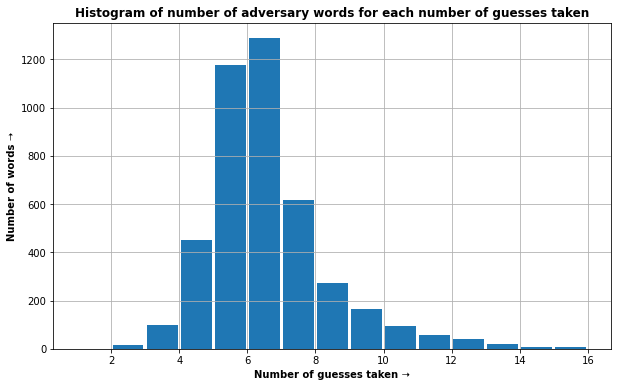

In [199]:
# Plotting a histogram of number of words at each value of number of guesses
# in order to get a feel for the number of guesses taken for all words

plt.figure(figsize = (10,6))
plt.grid(True)
plt.hist(list(guess_info.values()), bins = range(1, highest_guesses+1), rwidth = 0.9)
plt.xticks = range(1, highest_guesses+1)
plt.xlabel("Number of guesses taken \u279d", fontweight = 'bold')
plt.ylabel("Number of words \u279d", fontweight = 'bold')
plt.title("Histogram of number of adversary words for each number of guesses taken", fontweight = 'bold')
plt.show()

In [197]:
# Tracking guess history to analyse why WATS is the toughest word

_, guess_history, _ = algorithm(toughest_word, possible_words)
print(guess_history)

['TAES', 'TASK', 'BATS', 'CATS', 'FATS', 'GATS', 'HATS', 'LATS', 'MATS', 'NATS', 'OATS', 'PATS', 'QATS', 'RATS', 'VATS', 'WATS']


______________________________________________________________________________________________